<a href="https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/notebooks/competitions/AnimalAudioBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal Audio baseline

This notebook implements a baseline model for the animal audio classification competition.
The goal is to predict the species of the animal that is recorded in each row of the csv file. The audio is represented as gzipped and base64-encoded .ogg data. The notebook shows you how to get this data

The model here implemented is a very simple 1D CNN that processes raw data directly


In [1]:
#The following lines of code are used to set up data downloading from kaggle
#you can skip this block if you upload your data to the notebook in a different
#manner
!mkdir -p /root/.config/kaggle
!echo '{"username":"YOUR_KAGGLE_ID","key":"YOUR_TOKEN"}' > /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json
!kaggle competitions download -c animal-audios
!unzip animal-audios.zip

## 1. Imports and configuration variables

In [16]:
import os
import io
import gzip
import base64
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import torchaudio
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== CONFIG ==========
DATA_DIR = os.getenv('DATA_DIR', '.')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 15
ORIG_SR = 16000                # original sample rate
TARGET_SR = 8000               # downsampled rate. IT is used to resize the audio, to make it smaller (but with less resolution)
MAX_LEN = TARGET_SR * 10      # 10 sec at TARGET_SR => 80000
MIXUP_ALPHA = NotImplemented            # mixup parameter, to be implemented
CHECKPOINT = os.path.join(DATA_DIR, 'rawcnn_baseline.pt')
SUBMISSION = os.path.join(DATA_DIR, 'submission.csv')

## 2. Data management

In [4]:
class WaveformAugment:
    def __init__(self, noise_level=0.005, shift_ms=100, sample_rate=TARGET_SR):
        self.noise_level = noise_level
        self.shift = int(shift_ms/1000 * sample_rate)

    def __call__(self, waveform):
        gain = torch.rand(1, device=waveform.device) * (1.5 - 0.5) + 0.5
        waveform = waveform * gain
        noise = torch.randn_like(waveform) * self.noise_level
        waveform = waveform + noise
        offset = torch.randint(-self.shift, self.shift+1, (1,)).item()
        waveform = torch.roll(waveform, shifts=offset)
        return waveform

def decode_audio(b64_string, compressed=True):
    raw = base64.b64decode(b64_string)
    if compressed:
        raw = gzip.decompress(raw)
    waveform, sr = torchaudio.load(io.BytesIO(raw))
    waveform = waveform.mean(dim=0, keepdim=True)
    if sr != TARGET_SR:
        waveform = resampler(waveform)
    return waveform.squeeze(0)

class RawWaveDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df.reset_index(drop=True)
        self.augment = augment
        self.aug = WaveformAugment()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform = decode_audio(row['encoded_audio'])
        # pad/trim
        if waveform.size(0) > MAX_LEN:
            waveform = waveform[:MAX_LEN]
        else:
            waveform = F.pad(waveform, (0, MAX_LEN - waveform.size(0)))
        if self.augment:
            waveform = self.aug(waveform)
        # normalize per-sample
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-9)
        return waveform.unsqueeze(0), row['class']


#The resampler is used to reduce the size of the audio clip (loosing quality)
resampler = torchaudio.transforms.Resample(orig_freq=ORIG_SR, new_freq=TARGET_SR)


## 3. Model definition

In [5]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(out_ch)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, 1, padding)
        self.bn2 = nn.BatchNorm1d(out_ch)
        self.downsample = nn.Identity()
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_ch)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class RawResNetLight(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        self.layer1 = ResidualBlock1D(16, 32, stride=2)
        self.layer2 = ResidualBlock1D(32, 64, stride=2)
        self.pool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = self.global_pool(x).squeeze(-1)
        return self.fc(x)

## 4. Train Data loading

In [9]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
num_classes = len(df["class"].unique())

train_df, val_df = train_test_split(df, stratify=df['class'], test_size=0.2, random_state=42)
print(f"Data sizes, train: {len(train_df)}  val: {len(val_df)}")

In [24]:
counts = train_df['class'].value_counts().sort_index().values
#TODO: Implement a sensible sample_weights vector to deal with imbalance
sample_weights = torch.ones(len(train_df), dtype=torch.float32)/num_classes
#The WeightedRandomSampler allows you to undersample/oversample classes when
#generating the batches
sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights), replacement=True
)

train_ds = RawWaveDataset(train_df, augment=True)
val_ds = RawWaveDataset(val_df, augment=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

### 4.1 Listing some examples

In [27]:
import IPython.display as ipd
for i in range(2):
    row = df.iloc[i]
    waveform = decode_audio(row["encoded_audio"])
    print(f"row_id: {row['row_id']}, class: {row['class']}")
    ipd.display(ipd.Audio(waveform.numpy(), rate=ORIG_SR))

row_id: 3196, class: 4


row_id: 1692, class: 2


## 5. Train

Epoch 1 [TRAIN]: 100%|██████████| 25/25 [02:51<00:00,  6.84s/it]


Epoch 1: TrainLoss=1.8907 ValLoss=1.7914 ValF1=0.3165


Epoch 2 [TRAIN]: 100%|██████████| 25/25 [02:42<00:00,  6.48s/it]


Epoch 2: TrainLoss=1.6638 ValLoss=1.5561 ValF1=0.3618


Epoch 3 [TRAIN]: 100%|██████████| 25/25 [02:45<00:00,  6.63s/it]


Epoch 3: TrainLoss=1.5742 ValLoss=1.4967 ValF1=0.4459


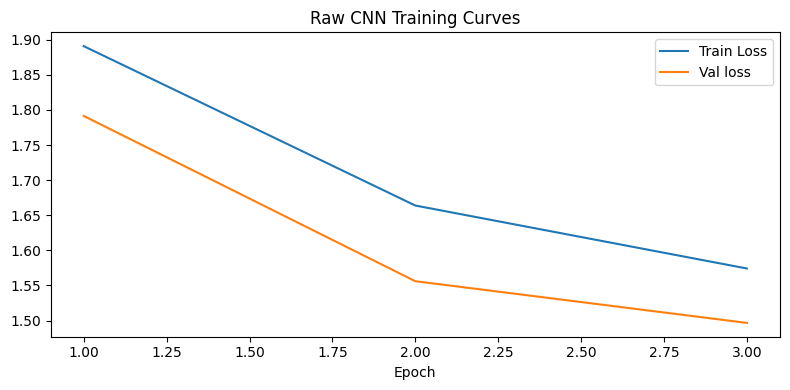

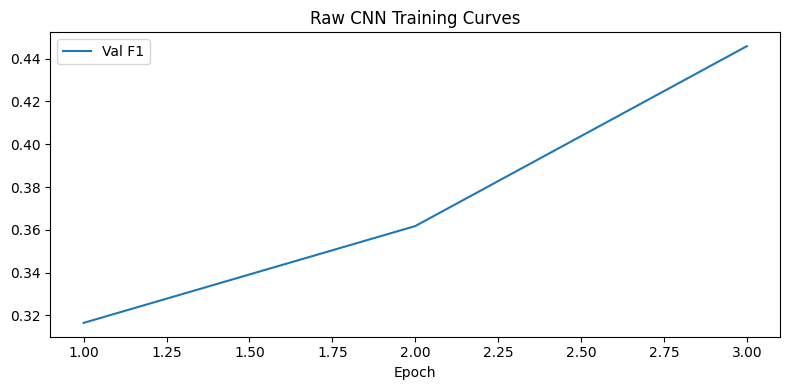

In [21]:
model = RawResNetLight(num_classes).to(DEVICE)
#TODO: Implement a sensible class_weights vector to deal with imbalance
class_weights = None #torch.tensor(1.0/counts, dtype=torch.float32, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0.0

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0
    for waveforms, labels in tqdm(train_loader, desc=f"Epoch {epoch} [TRAIN]"):
        waveforms, labels = waveforms.to(DEVICE), labels.to(DEVICE)
        if MIXUP_ALPHA is not NotImplemented:
            raise NotImplementedError("You might want to implement mixup")
        else:
            outputs = model(waveforms)
            loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_loader))

    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for waveforms, labels in val_loader:
            waveforms, labels = waveforms.to(DEVICE), labels.to(DEVICE)
            outputs = model(waveforms)
            preds =outputs.argmax(dim=1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    val_losses.append(running_loss/len(val_loader))
    f1 = f1_score(y_true, y_pred, average='macro')

    val_f1s.append(f1)
    scheduler.step(f1)
    print(f"Epoch {epoch}: TrainLoss={train_losses[-1]:.4f} ValLoss={val_losses[-1]:.4f} ValF1={f1:.4f}")
    if f1 > best_f1: best_f1 = f1; torch.save(model.state_dict(), CHECKPOINT)
    #TODO: implement early stopping

# training curves
plt.figure(figsize=(8,4))
plt.plot(range(1,NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1,NUM_EPOCHS+1), val_losses,    label='Val loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Raw CNN Training Curves')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(1,NUM_EPOCHS+1), val_f1s,    label='Val F1')
plt.xlabel('Epoch')
plt.legend()
plt.title('Raw CNN Training Curves')
plt.tight_layout()
plt.show()

In [22]:
# inference
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
test_df['class'] = 0
test_ds = RawWaveDataset(test_df, augment=False)
test_loader = DataLoader(test_ds, batch_size=1) #In practise, using a batch_size=1 is not efficient
model.load_state_dict(torch.load(CHECKPOINT, map_location=DEVICE)); model.eval()
preds = []
with torch.no_grad():
    for waveforms, _ in tqdm(test_loader, desc='Inference'):
        waveforms = waveforms.to(DEVICE)
        preds.append(model(waveforms).argmax(dim=1).item())
pd.DataFrame({'row_id': test_df['row_id'], 'class': preds}).to_csv(SUBMISSION, index=False)
print(f"Submission saved to {SUBMISSION}")


Inference: 100%|██████████| 1664/1664 [01:47<00:00, 15.50it/s]

Submission saved to ./submission.csv


# HINTS TO IMPROVE PERFORMANCE
Implement the TODOs in the code. In addition, you could try to use
1. Alternative architectures
    1. 2D CNN: Try converting raw waveforms to time frequency representations (e.g., Mel-spectrograms or MFCCs) and feed into a 2D CNN for richer features.
    2. RNNs.
    3. Pretrained Models: Leverage pretrained audio encoders like Wav2Vec2, HuBERT, or YAMNet and fine-tune on your downstream task for faster convergence.
2. Data Augmentation: Explore SpecAugment (time/frequency masking), random cropping, mixup, and pitch/time shifts to increase robustness.
3. Ensembling: Combine predictions from multiple model types (raw-CNN, spectrogram-CNN, transformer) for a final performance boost.

Don't forget to perform Hyperparameter search and to store the model checkpoints and the logs and graphs, you might need them later on.